## Quadrotor Simulator with Animation 
#### Author: Mahdi Shahrajabian, Feb 2025

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from IPython.display import Video, display, clear_output
import cv2
import gymnasium as gym
from gym import spaces

from quadrotor_parameters import parameters


In [89]:
class QuadrotorEnv:
    def __init__(self, parameters:dict, initial_state, dt=0.01):
        # z axis is downward!
        # State variables: [x, y, z, phi, theta, psi, vx, vy, vz, p, q, r]
        # x, y, z -> position, 
        # phi, theta, psi -> attitude (roll, pitch, yaw)
        # vx, vy, vz -> translational velocities, 
        # p, q, r -> angular velocities
        self.initial_state = initial_state  # Initialize state vector
        self.state = initial_state 
        self.parameters = parameters
        self.low_state = np.array(
            [-self.parameters["max_h_pos"], -self.parameters["max_h_pos"], self.parameters["min_z"], -self.parameters["max_phi_theta"],
             -self.parameters["max_phi_theta"], -self.parameters["max_psi"],-np.finfo(np.float32).max, -np.finfo(np.float32).max,
             -np.finfo(np.float32).max, -np.finfo(np.float32).max,-np.finfo(np.float32).max, -np.finfo(np.float32).max], dtype=np.float32)
        
        self.high_state = np.array(
            [self.parameters["max_h_pos"], self.parameters["max_h_pos"], self.parameters["max_z"], self.parameters["max_phi_theta"], 
             self.parameters["max_phi_theta"], self.parameters["max_psi"], np.finfo(np.float32).max, np.finfo(np.float32).max, 
             np.finfo(np.float32).max, np.finfo(np.float32).max, np.finfo(np.float32).max, np.finfo(np.float32).max], dtype=np.float32)

        self.min_action = np.array([self.parameters["min_thrust"], self.parameters["min_thrust"]
                                    , self.parameters["min_thrust"], self.parameters["min_thrust"]], dtype=np.float32)
        self.max_action = np.array([self.parameters["max_thrust"], self.parameters["max_thrust"],
                                    self.parameters["max_thrust"], self.parameters["max_thrust"]], dtype=np.float32)
        
        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            dtype=np.float32)
        
        self.observation_space = spaces.Box(
            low=self.low_state,
            high=self.high_state,
            dtype=np.float32)

          
        # Obstacles (two first elements are the centers position in x-y plane and the third is the radius)
        self.obstacles = [(30, -10, 2), (75, 0, 2), (75, 20, 3), (20, 10, 3), (50, 10, 2)]
        
        # Simulation parameters 
        self.dt = dt  # Time step (s)
        self.t = 0.0
        self.time = []
        
    def wrap_angle(self,angle):
        """Wrap angle between -pi and pi"""
        return (angle + np.pi) % (2 * np.pi) - np.pi

    def dynamics(self, state, inputs):
        x, y, z, phi, theta, psi, vx, vy, vz, p, q, r = state
      
        for i in range(4):
            if inputs[i] > self.parameters["max_thrust"]:
                inputs[i] = self.parameters["max_thrust"]
            if inputs[i] < self.parameters["min_thrust"]:
                inputs[i] = self.parameters["min_thrust"]
                
        T1, T2, T3, T4 = inputs  # Motor thrust inputs
        total_thrust = T1 + T2 + T3 + T4
   
        # X-config 
        #  forward
        #  4↓     1↑
        #   \    /
        #    \  / 
        #    / \ 
        #   /   \
        #  3↑     2↓
        ld = self.parameters["d"] * np.cos(np.pi/4)
        tau_phi = ld * (T3 + T4 - T1 - T2)
        tau_theta = ld * (T1 + T4 - T2 - T3)
        tau_psi = self.parameters["gamma"] * (T1 - T2 + T3 - T4)
        
        # Equations of motion (ignoring the gyroscopic moment and aerodynamic forces and moments)
        dx = vx
        dy = vy
        dz = vz

        dphi = p + (q * np.sin(phi) + r * np.cos(phi)) * np.tan(theta)
        dtheta = q * np.cos(phi) - r * np.sin(phi)
        dpsi = (q * np.sin(phi) + r * np.cos(phi)) / np.cos(theta)

        dvx = - (total_thrust / self.parameters["m"]) * (np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi))
        dvy = - (total_thrust / self.parameters["m"]) * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
        dvz = self.parameters["g"] - (total_thrust / self.parameters["m"]) * np.cos(phi) * np.cos(theta)
    
        dp = ((self.parameters["Iyy"] - self.parameters["Izz"]) * q * r + tau_phi) / self.parameters["Ixx"]
        dq = ((self.parameters["Izz"] - self.parameters["Ixx"]) * p * r + tau_theta) / self.parameters["Iyy"]
        dr = ((self.parameters["Ixx"] - self.parameters["Iyy"]) * p * q + tau_psi) / self.parameters["Izz"]
  
        return np.array([dx, dy, dz, dphi, dtheta, dpsi, dvx, dvy, dvz, dp, dq, dr])

    def runge_kutta(self, state, inputs):
        # Runge-Kutta 4th order integration for updating the state
        k1 = self.dynamics(state, inputs)
        k2 = self.dynamics(state + 0.5 * self.dt * k1, inputs)
        k3 = self.dynamics(state + 0.5 * self.dt * k2, inputs)
        k4 = self.dynamics(state + self.dt * k3, inputs)

        new_state = state + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        # Wrap angles to the range [-pi, pi]
        new_state[3] = self.wrap_angle(new_state[3])  # Roll (phi)
        new_state[4] = self.wrap_angle(new_state[4])  # Pitch (theta)
        new_state[5] = self.wrap_angle(new_state[5])  # Yaw (psi)
        
        return new_state

    def step(self, inputs):
        # Update state with Runge-Kutta
        p_p = self.state[:3] # previous position 
        self.state = self.runge_kutta(self.state, inputs)
        p = self.state[:3] # current position 
        self.t += self.dt
        self.time.append(self.t)
        done = False
       
        # Infeasible states 
        for i in range(12):
            if self.state[i] > self.high_state[i]:
                self.state[i] = self.high_state[i]
                done = True
               
            if self.state[i] < self.low_state[i]:
                self.state[i] = self.low_state[i]
                done = True
             
        
        # Collision detection -------------------------------------------------------------------------
        if not done:
            for i in range(len(self.obstacles)):
                obs = self.obstacles[i]
                if np.linalg.norm(obs[:2]-self.state[:2])<1.25*self.parameters["d"]:
                    done = True
      
        # Ground Contact 
        if not done:
            if np.abs(self.state[2])<0.3:
                done = True
        
        return self.state, done

    def reset(self):
        # Reset the state to the initial condition
        self.state = initial_state
        self.t = 0.0
        self.time = []
        return self.state

    
    def plot_states(self, state, time):
        # Create subplots with 6 plots: Translational states (3) and Rotational states (3)
        fig, axes = plt.subplots(2, 3, figsize=(15, 7))

        # Labels for the plots
        axes[0, 0].set_title('X Position')
        axes[0, 1].set_title('Y Position')
        axes[0, 2].set_title('Z Position')
        axes[1, 0].set_title('Roll Angle')
        axes[1, 1].set_title('Pitch Angle')
        axes[1, 2].set_title('Yaw Angle')

        axes[0, 0].set_xlabel('Time (s)')
        axes[0, 1].set_xlabel('Time (s)')
        axes[0, 2].set_xlabel('Time (s)')
        axes[1, 0].set_xlabel('Time (s)')
        axes[1, 1].set_xlabel('Time (s)')
        axes[1, 2].set_xlabel('Time (s)')
        
        axes[0, 0].set_ylabel(r'$x$ (m)')
        axes[0, 1].set_ylabel(r'$y$ (m)')
        axes[0, 2].set_ylabel(r'$z$ (m)')
        axes[1, 0].set_ylabel(r'$\phi$ (rad)')
        axes[1, 1].set_ylabel(r'$\theta$ (rad)')
        axes[1, 2].set_ylabel(r'$\psi$ (rad)')
        
        axes[0, 0].grid()
        axes[0, 1].grid()
        axes[0, 2].grid()
        axes[1, 0].grid()
        axes[1, 1].grid()
        axes[1, 2].grid()
        
        axes[0, 0].plot(time, state[0], 'r')  # Plot X position
        axes[0, 1].plot(time, state[1], 'g')  # Plot Y position
        axes[0, 2].plot(time, state[2], 'b')  # Plot Z position
        axes[1, 0].plot(time, state[3], 'r')  # Plot Roll (phi)
        axes[1, 1].plot(time, state[4], 'g')  # Plot Pitch (theta)
        axes[1, 2].plot(time, state[5], 'b')  # Plot Yaw (psi)

        plt.tight_layout()
        plt.show()

## Simulation 

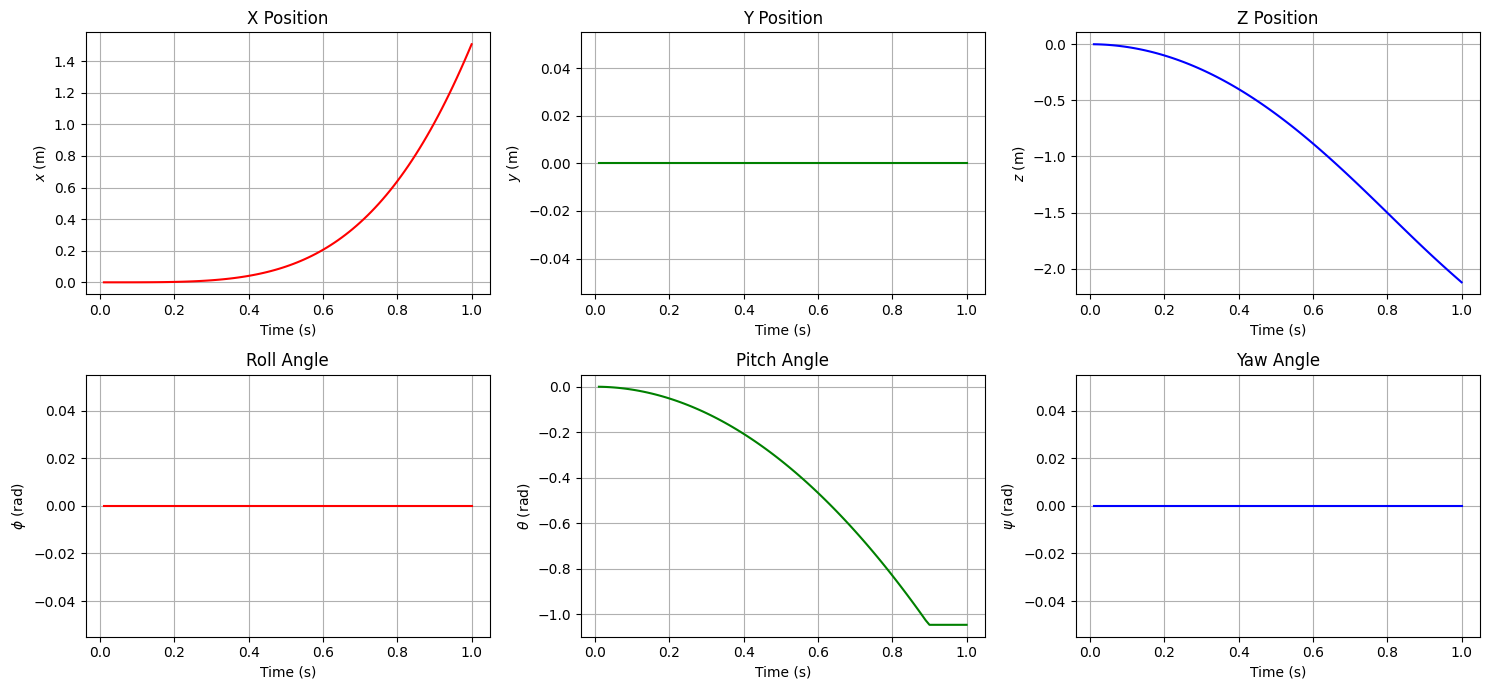

In [76]:
initial_state = np.zeros((12,1))
env = QuadrotorEnv(parameters, initial_state, dt=0.01)
# Reset the environment and render the quadrotor
env.reset()
#env.render()
hist = []
T_hover = parameters["m"]*parameters["g"]/4.0
# Simulation Loop 
for k in range (100):
    #s,done= env.step([T_hover,T_hover,T_hover,T_hover])
    s, done = env.step([21,22,22,21]) # Move forward 
    hist.append(np.squeeze(s))
# Plot 
env.plot_states(np.transpose(hist),env.time)

In [113]:
def quad_scene(t,position_vec, EA_vec, video_path = "render.mp4"):
    """
    Plot 3D scene with quadrotor position, arms, propellers, and path.
    """
    arm_length = 0.6  # Length of the quadrotor arms
    prop_radius = 0.1  # Radius of the propellers
    flash_length = 0.1  # Length of the forward direction arrow
    body_radius=0.1
    height=10
    # Define points for initial, target, and final
    initial_point = (0, 0, 0)
    final_point = (100, 30, -2)
    cylinders = [(30, -10, 2), (75, 0, 2), (75, 20, 3), (20, 10, 3), (50, 10, 2)]

    fps=10
    resolution=50

    # # Clear previous plot contents
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    # Create a video writer
    frame_width, frame_height = 900, 500  # Dimensions for the video
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Codec for mp4
    out = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    
    for i in range(len(t)):
        ax1.clear()  # Clear the previous frame
        ax2.clear()  # Clear the previous frame
        position = position_vec[i]
        euler_angles = EA_vec[i]
        quad_x, quad_y, quad_z = position
        
        
        # Plot cylinders in 3D (obstacles)
        for x_center, y_center, radius in cylinders:
            z = np.linspace(0, -height, resolution)
            theta = np.linspace(0, 2 * np.pi, resolution)
            theta_grid, z_grid = np.meshgrid(theta, z)
            x = x_center + radius * np.cos(theta_grid)
            y = y_center + radius * np.sin(theta_grid)
    
            # Plot the surface
            ax1.plot_surface(x, y, z_grid, alpha=0.5, color='blue')
    
        # Plot points as spheres in 3D (initial, final points)
        def plot_sphere(ax, center, radius, color):
            u, v = np.mgrid[0:2 * np.pi:resolution * 1j, 0:np.pi:resolution * 1j]
            x = center[0] + radius * np.cos(u) * np.sin(v)
            y = center[1] + radius * np.sin(u) * np.sin(v)
            z = center[2] + radius * np.cos(v)
            ax.plot_surface(x, y, z, color=color, alpha=0.9)
    
        # Plot points
        plot_sphere(ax1, initial_point, 0.2, 'orange')
        plot_sphere(ax1, final_point, 0.2, 'green')
    
        # Plot Quadrotor body as a sphere
        phi, theta, psi = euler_angles
        R_x = np.array([[1, 0, 0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])
        
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])
        
        R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi), 0],
                        [0, 0, 1]])
        
        R = np.dot(R_z, np.dot(R_y, R_x))  # Total rotation matrix
        
        u, v = np.mgrid[0:2 * np.pi:100j, 0:np.pi:50j]
        x = body_radius * np.cos(u) * np.sin(v)
        y = body_radius * np.sin(u) * np.sin(v)
        z = body_radius * np.cos(v)
        
        # Apply rotation and translation to the body
        body_points = np.array([x.flatten(), y.flatten(), z.flatten()])
        body_rotated = np.dot(R, body_points).reshape(3, *x.shape)
        ax1.plot_surface(body_rotated[0] + quad_x, body_rotated[1] + quad_y, body_rotated[2] + quad_z, color='red', alpha=0.7)

        forward_vector = np.array([1, 0, 0])  # The x-axis in the quadrotor's frame

        # Apply the rotation matrix to the forward vector to get the rotated forward direction
        rotated_forward_vector = np.dot(R, forward_vector)
        
        # Define the length of the forward "flash" (arrow)
        flash_length = 1
        
        # Calculate the end position of the forward flash line
        flash_end = position + rotated_forward_vector * flash_length
        
        # Plot the forward flash line (a line from the center to the end of the forward vector)
        ax1.plot([quad_x, flash_end[0]], 
                [quad_y, flash_end[1]], 
                [quad_z, flash_end[2]], 
                color='green', lw=2, label='Forward Direction')
        
        # Optionally, you can add an arrow to indicate the direction more clearly
        ax1.quiver(quad_x, quad_y, quad_z, 
                  rotated_forward_vector[0], rotated_forward_vector[1], rotated_forward_vector[2], 
                  color='green', length=flash_length, normalize=True)
        
        # Plot arms and propellers
        arm_directions = [
            [arm_length / np.sqrt(2), arm_length / np.sqrt(2), 0],
            [-arm_length / np.sqrt(2), arm_length / np.sqrt(2), 0],
            [-arm_length / np.sqrt(2), -arm_length / np.sqrt(2), 0],
            [arm_length / np.sqrt(2), -arm_length / np.sqrt(2), 0]
        ]
    
        for direction in arm_directions:
            arm_end = position + np.dot(R, direction)
            ax1.plot([quad_x, arm_end[0]], [quad_y, arm_end[1]], [quad_z, arm_end[2]], color='red', lw=2)
    
            # Create propellers at the end of each arm
            prop_position = arm_end
            u, v = np.mgrid[0:2 * np.pi:100j, 0:np.pi:50j]
            x = prop_radius * np.cos(u) * np.sin(v)
            y = prop_radius * np.sin(u) * np.sin(v)
            z = prop_radius * np.cos(v)
            prop_points = np.array([x.flatten(), y.flatten(), z.flatten()])
            prop_rotated = np.dot(R, prop_points).reshape(3, *x.shape)
            ax1.plot_surface(prop_position[0] + prop_rotated[0], prop_position[1] + prop_rotated[1], prop_position[2] + prop_rotated[2], color='black', alpha=0.7)
        
        # Set plot limits for both 3D and 2D views
        ax1.set_xlim([-4 + quad_x, 4 + quad_x])
        ax1.set_ylim([-4 + quad_y, 4 + quad_y])
        ax1.set_zlim([-8 + quad_z, 0 +quad_z])
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('Y-axis')
        ax1.set_zlabel('Z-axis')
        ax1.set_title('3D Flight Path')
        ax1.invert_yaxis()  # Reverse the y-axis
        ax1.invert_zaxis()  # Reverse the z-axis
        ax1.view_init(elev=62, azim=125) # 30 140
    
        # 2D top view (XY-plane)
        # Rotation matrix for heading angle (yaw)
        R_z = np.array([[np.cos(psi+np.pi/4), -np.sin(psi+np.pi/4), 0],
                        [np.sin(psi+np.pi/4), np.cos(psi+np.pi/4), 0],
                        [0, 0, 1]])
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])
                         
        # Define arm offsets in the body frame (cross arrangement)
        arm_offsets_body = np.array([
            [8*arm_length / 2, 0, 0],  # Front
            [-8*arm_length / 2, 0, 0],  # Back
            [0, 8*arm_length / 2, 0],  # Left
            [0, -8*arm_length / 2, 0]  # Right
        ])

        # Rotate the arm offsets to the global frame
        arm_offsets_global = np.dot(R_z, arm_offsets_body.T).T

        # Plot arms as lines
        for offset in arm_offsets_global:
            arm_x, arm_y = quad_x + offset[0], quad_y + offset[1]
            ax2.plot([quad_y, arm_y], [quad_x, arm_x], color="red", lw=2)

        # Plot propellers (circles) at the ends of arms
        for offset in arm_offsets_global:
            prop_x, prop_y = quad_x + offset[0], quad_y + offset[1]
            propeller = plt.Circle((prop_y, prop_x), prop_radius*8, color="gray", alpha=0.8)
            ax2.add_artist(propeller)

        # Plot forward direction arrow
        forward_vector = np.array([np.sqrt(2)/2, -np.sqrt(2)/2, 0])  # The x-axis in the quadrotor's body frame
        rotated_forward_vector = np.dot(R_z, forward_vector)  # Rotate to the global frame
        flash_end = np.array([quad_y, quad_x]) + np.array([rotated_forward_vector[1],rotated_forward_vector[0]]) * flash_length*5

        ax2.arrow(
            quad_y, quad_x,  # Start of the arrow
            rotated_forward_vector[1] * flash_length*5, rotated_forward_vector[0] * flash_length*5,  # Arrow components
            head_width=0.6, head_length=0.5, fc="green", ec="green", label="_nolegend_"
        )
        
  
        for x_center, y_center, radius in cylinders:
            circle = plt.Circle((y_center, x_center), radius, color='blue', alpha=0.8)
            ax2.add_artist(circle)
        
        ax2.scatter(initial_point[1], initial_point[0], color='orange', label='Initial point', s=20)
        ax2.scatter(final_point[1], final_point[0], color='green', label='Final point', s=20)
    
        # Plot the trajectory in the 2D view (black line)
        x = [pos[0] for pos in position_vec[:i]]
        y = [pos[1] for pos in position_vec[:i]]
        ax2.plot(y, x, color='black')  # Plot trajectory
    
        ax2.set_xlim(-50, 50)
        ax2.set_ylim(-5, 110)
        ax2.set_xlabel('Y-axis')
        ax2.set_ylabel('X-axis')
        ax2.set_title('2D Top View')
        ax2.set_title(f'2D Top View\nTime: {t[i]:.2f} sec')
        ax2.set_aspect('equal', 'box')  # Ensure equal scaling for 2D view
        # Update for 2D top view
        ax2.legend()

        fig.tight_layout()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Resize and write to video
        img_resized = cv2.resize(img, (frame_width, frame_height))
        out.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
        
    out.release()
    plt.close(fig)
    display(Video(video_path))


## Animation 

In [114]:
# Creating a dataset for animation (it can be obtained from the simulation)
position_vec = []
euler_angles = []
t = []
t0 = 0
dt = 0.1
for i in range(100):
    t0 += dt
    t.append(t0)
    position_vec.append(np.array([1*i,0.1*i,-1]))
    euler_angles.append(np.array([0,0,0.05*i]))

quad_scene(t,position_vec, euler_angles)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_14068\590364424.py:208: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
